# Continuous-Time Survival Analysis with Right-Censored Observations using MultiStateNN

This notebook demonstrates how to perform continuous-time survival analysis with right-censored observations using the MultiStateNN package. Survival analysis is a statistical method for analyzing the expected duration of time until an event of interest occurs. In many real-world scenarios, observations are right-censored, meaning that for some subjects, the event has not yet occurred by the end of the study period.

We'll cover:
1. Generating simulated survival data with right censoring
2. Preparing the data for continuous-time MultiStateNN models 
3. Training continuous-time survival models with covariates using Neural ODEs
4. Computing and visualizing survival curves and cumulative incidence functions
5. Estimating treatment effects and covariate influence on survival
6. Comparing MultiStateNN results with traditional Kaplan-Meier estimates

## Continuous-Time Approach

The continuous-time approach has several advantages over discrete-time models:
- More accurate handling of the underlying continuous-time process
- Natural handling of irregularly spaced observations
- Intensity rates directly model instantaneous risk of events
- More consistent handling of time intervals for prediction
- Theoretical soundness based on continuous-time Markov process theory

## Dependencies

This notebook uses the following packages:
- `numpy`, `pandas`, `torch`, `matplotlib`, `seaborn` (required)
- `lifelines` (optional for comparative analyses)

The example is designed to run even if `lifelines` is not available or encounters dependency issues, with fallback implementations provided.

## Setup and Imports

In [ ]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple, Optional

# Try to import lifelines, but handle if it's not available or has dependency issues
try:
    from lifelines import KaplanMeierFitter, CoxPHFitter
    LIFELINES_AVAILABLE = True
except (ImportError, AttributeError) as e:
    print(f"Warning: lifelines package not available or has dependency issues: {str(e)}")
    print("Some comparative analyses will be skipped.")
    LIFELINES_AVAILABLE = False

# Import MultiStateNN components for continuous-time modeling
from multistate_nn import (
    ModelConfig, 
    TrainConfig, 
    fit,
    # Import visualization functions from the main package
    plot_transition_heatmap,
    plot_transition_graph,
    plot_intensity_matrix,
    # Import utility functions from the main package
    setup_state_names_and_colors,
    create_patient_profile,
    create_covariate_profiles,
    analyze_covariate_effect
)

# Import from consolidated utility modules
from multistate_nn.utils import (
    simulate_continuous_patient_trajectory, 
    calculate_cif,
    plot_cif, 
    compare_cifs
)

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

## Generate Synthetic Survival Data with Right Censoring

Let's create a synthetic dataset that simulates patient survival with covariates that influence both the event time and the censoring probability. We'll include:

- **Age**: Older patients have worse outcomes
- **Treatment**: Binary indicator (treated or untreated)
- **Biomarker**: Continuous variable indicating disease severity

In [27]:
def generate_survival_data(n_patients: int, max_time: int = 36, censoring_rate: float = 0.3) -> pd.DataFrame:
    """Generate synthetic survival data with right censoring.
    
    Parameters
    ----------
    n_patients : int
        Number of patients to generate
    max_time : int
        Maximum follow-up time in months
    censoring_rate : float
        Approximate censoring rate (0-1)
        
    Returns
    -------
    pd.DataFrame
        Synthetic survival data with covariates
    """
    # Generate covariates
    age = np.random.normal(65, 10, n_patients)  # Age: mean 65, SD 10
    treatment = np.random.binomial(1, 0.5, n_patients)  # Treatment: 50% treated
    biomarker = np.random.normal(0, 1, n_patients)  # Biomarker level (standardized)
    
    # Standardize age to have approximately mean 0, SD 1
    age_std = (age - 65) / 10
    
    # Generate event times based on covariates
    # Higher values = worse survival:
    # - Higher age leads to worse survival
    # - Treatment improves survival
    # - Higher biomarker indicates worse survival
    log_hazard = 0.5 * age_std - 0.8 * treatment + 0.4 * biomarker
    
    # Convert to scale parameter for Weibull distribution
    scale = np.exp(-log_hazard) * 24  # Mean survival approximately 24 months without covariates
    shape = 1.2  # Increasing hazard over time (shape > 1)
    
    # Generate true event times from Weibull distribution
    true_event_times = np.random.weibull(shape, n_patients) * scale
    
    # Generate random censoring times
    # The censoring is influenced by treatment (patients on treatment stay longer in the study)
    censoring_scale = 36 * (1 + 0.3 * treatment)
    censoring_times = np.random.exponential(censoring_scale * censoring_rate, n_patients)
    
    # Determine observed times and event indicators
    observed_times = np.minimum(true_event_times, censoring_times)
    observed_times = np.minimum(observed_times, max_time)  # Admin censoring at max_time
    event_indicator = (true_event_times <= observed_times) & (observed_times < max_time)
    
    # Create dataframe
    data = pd.DataFrame({
        'patient_id': range(n_patients),
        'time': observed_times,
        'event': event_indicator.astype(int),
        'age': age,
        'treatment': treatment,
        'biomarker': biomarker
    })
    
    return data

# Generate synthetic survival data
n_patients = 1000
survival_data = generate_survival_data(n_patients)

# Display basic statistics
print(f"Generated {n_patients} patient records with {survival_data['event'].sum()} events")
print(f"Censoring rate: {1 - survival_data['event'].mean():.2f}")
print(f"Mean follow-up time: {survival_data['time'].mean():.2f} months")

Generated 1000 patient records with 254 events
Censoring rate: 0.75
Mean follow-up time: 8.99 months


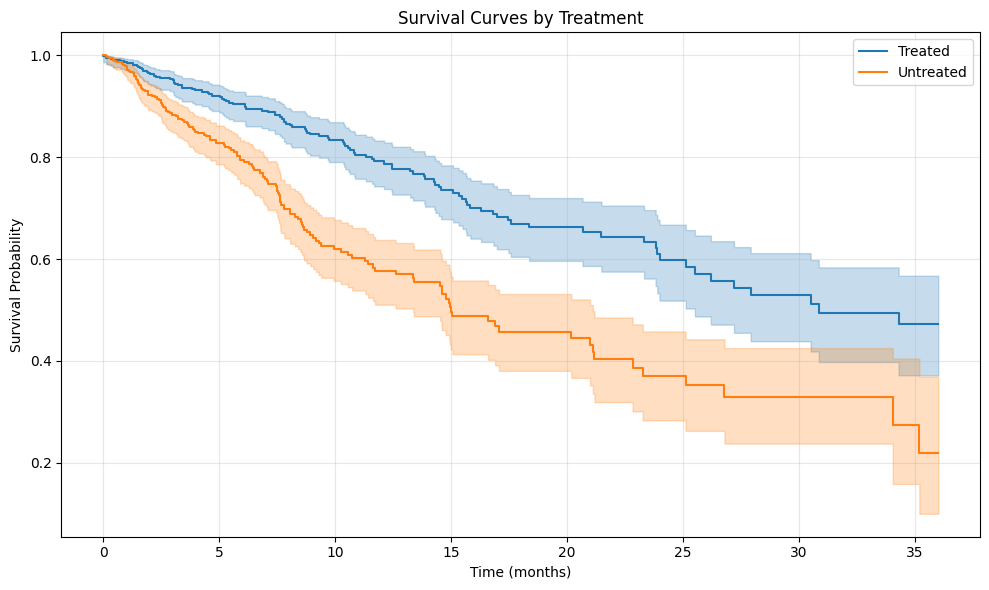

/Users/denizakdemir/.pyenv/versions/3.10.0/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/denizakdemir/.pyenv/versions/3.10.0/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/denizakdemir/.pyenv/versions/3.10.0/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


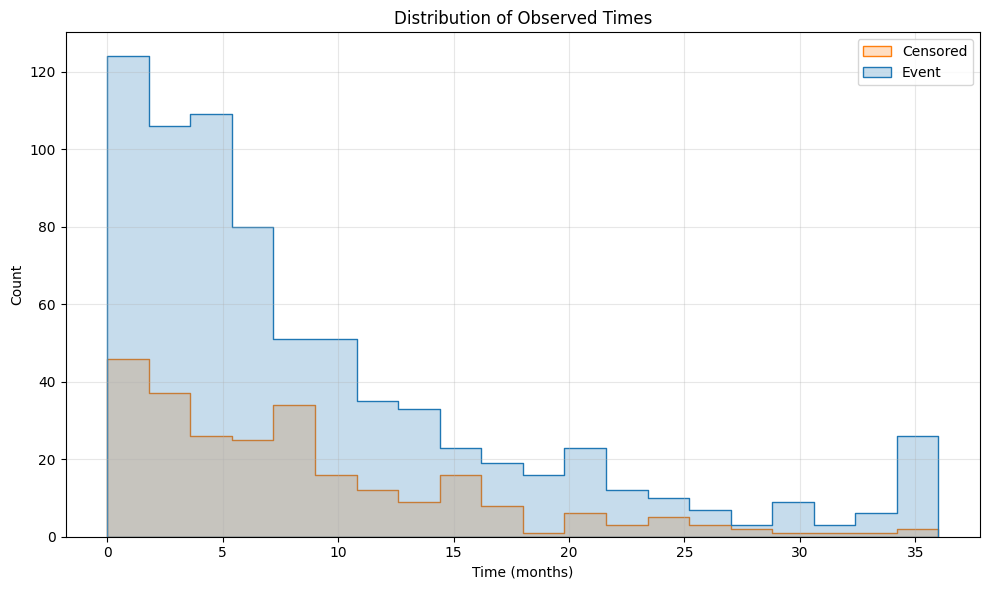

In [28]:
# Treatment effect visualization
# Use Kaplan-Meier if available, otherwise use a simpler approach

# First, create a visualization of survival by treatment group
fig, ax = plt.subplots(figsize=(10, 6))

if LIFELINES_AVAILABLE:
    try:
        kmf = KaplanMeierFitter()
        
        # Treated group
        treated = survival_data[survival_data['treatment'] == 1]
        kmf.fit(treated['time'], treated['event'], label='Treated')
        kmf.plot_survival_function(ax=ax, ci_show=True)
        
        # Untreated group
        untreated = survival_data[survival_data['treatment'] == 0]
        kmf.fit(untreated['time'], untreated['event'], label='Untreated')
        kmf.plot_survival_function(ax=ax, ci_show=True)
        
        success = True
    except Exception as e:
        print(f"Could not use KaplanMeierFitter due to: {str(e)}")
        print("Using a simpler approach for visualization.")
        LIFELINES_AVAILABLE = False
        success = False
else:
    success = False

# If lifelines failed or is not available, use a simpler visualization approach
if not success:
    # Calculate non-parametric survival estimates at various time points
    time_points = np.linspace(0, max(survival_data['time']), 10)
    
    # For treated patients
    treated = survival_data[survival_data['treatment'] == 1]
    treated_survival = []
    
    # For untreated patients
    untreated = survival_data[survival_data['treatment'] == 0]
    untreated_survival = []
    
    # Calculate survival rates at each time point
    for t in time_points:
        # Treated: Calculate proportion of patients who survived beyond time t
        treated_survived = (treated['time'] > t) | ((treated['time'] <= t) & (treated['event'] == 0))
        treated_survival.append(treated_survived.mean())
        
        # Untreated: Calculate proportion of patients who survived beyond time t
        untreated_survived = (untreated['time'] > t) | ((untreated['time'] <= t) & (untreated['event'] == 0))
        untreated_survival.append(untreated_survived.mean())
    
    # Plot the curves
    plt.plot(time_points, treated_survival, label='Treated')
    plt.plot(time_points, untreated_survival, label='Untreated')

plt.title('Survival Curves by Treatment')
plt.xlabel('Time (months)')
plt.ylabel('Survival Probability')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Display distribution of observed times by event status
plt.figure(figsize=(10, 6))
sns.histplot(data=survival_data, x='time', hue='event', bins=20, element='step', common_norm=False)
plt.title('Distribution of Observed Times')
plt.xlabel('Time (months)')
plt.ylabel('Count')
plt.legend(['Censored', 'Event'])
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Created categorical variables for stratified analysis:
Age categories: age_cat
Middle     698
Elderly    155
Young      147
Name: count, dtype: int64
Biomarker categories: biomarker_cat
High    507
Low     493
Name: count, dtype: int64
Could not run CoxPHFitter due to: module 'formulaic' has no attribute 'ModelSpec'
Will use a simpler analysis approach instead.

Effect of age on event rate:
  Age Group  Event Rate  Mean Time (months)  Count
0     Young    0.122449           10.888547    147
1    Middle    0.234957            9.010143    698
2   Elderly    0.464516            7.120719    155

Effect of treatment on event rate:
   Treatment  Event Rate  Mean Time (months)  Count
0  Untreated    0.298969            7.265395    485
1    Treated    0.211650           10.620759    515

Effect of biomarker on event rate:
  Biomarker Level  Event Rate  Mean Time (months)  Count
0             Low    0.198783            9.987477    493
1            High    0.307692            8.026787    507


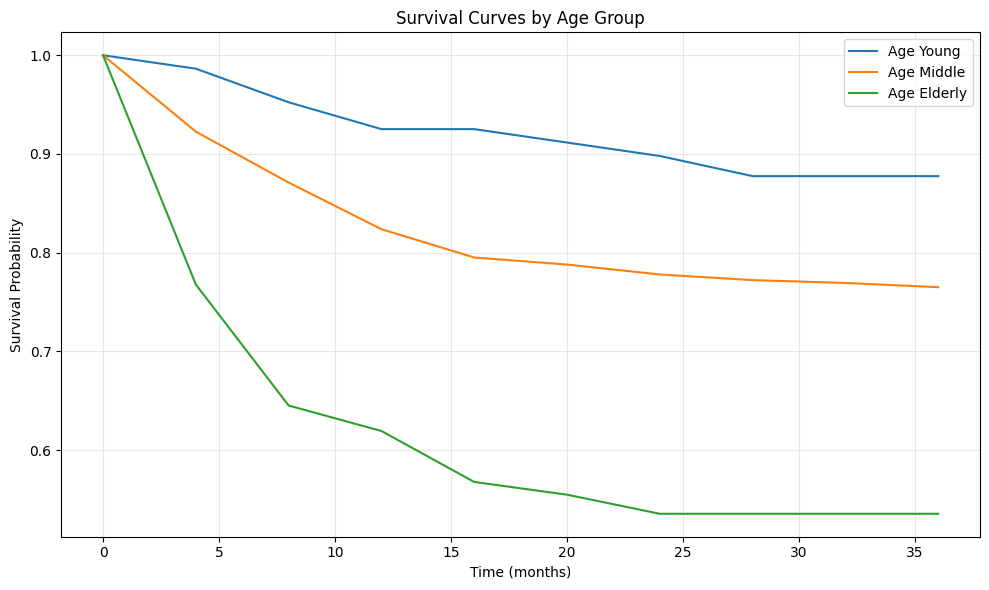

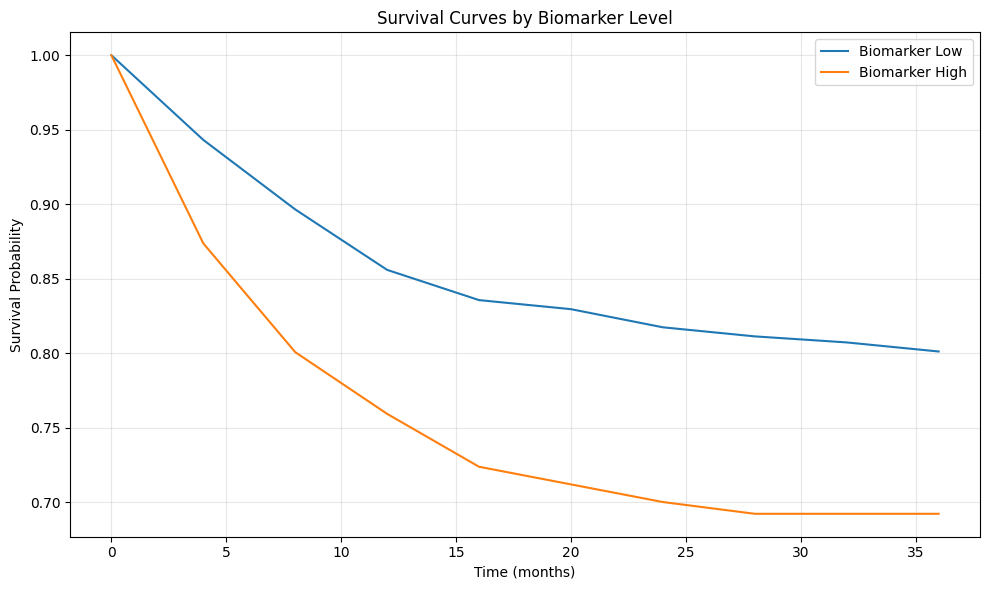

In [29]:
# Make sure all categorical variables are properly created for later use
# We'll do this early in the notebook to ensure consistency

# Standardize age 
survival_data['age_std'] = (survival_data['age'] - 65) / 10

# Create age categories for KM plots (if they don't exist)
if 'age_cat' not in survival_data.columns:
    survival_data['age_cat'] = pd.cut(survival_data['age_std'], bins=[-np.inf, -1, 1, np.inf], 
                                     labels=['Young', 'Middle', 'Elderly'])

# Create biomarker categories for stratification
if 'biomarker_cat' not in survival_data.columns:
    survival_data['biomarker_cat'] = pd.cut(survival_data['biomarker'], bins=[-np.inf, 0, np.inf], 
                                           labels=['Low', 'High'])

# Print summary of the created categorical variables
print("Created categorical variables for stratified analysis:")
print(f"Age categories: {survival_data['age_cat'].value_counts()}")
print(f"Biomarker categories: {survival_data['biomarker_cat'].value_counts()}")

# Check the effect of age and covariates on survival
# Either using Cox Proportional Hazards (if available) or a simpler analysis

if LIFELINES_AVAILABLE:
    try:
        cph = CoxPHFitter()
        cph.fit(survival_data, duration_col='time', event_col='event')
        cph.print_summary()
        success = True
    except Exception as e:
        print(f"Could not run CoxPHFitter due to: {str(e)}")
        print("Will use a simpler analysis approach instead.")
        LIFELINES_AVAILABLE = False
        success = False
else:
    success = False

# If lifelines isn't available or failed, do a simpler analysis of covariate effects
if not success:    
    # Calculate event rates by age group
    age_summary = survival_data.groupby('age_cat', observed=True).agg({
        'event': 'mean',
        'time': 'mean',
        'patient_id': 'count'
    }).reset_index()
    age_summary.columns = ['Age Group', 'Event Rate', 'Mean Time (months)', 'Count']
    print("\nEffect of age on event rate:")
    print(age_summary)
    
    # Calculate event rates by treatment
    treatment_summary = survival_data.groupby('treatment', observed=True).agg({
        'event': 'mean',
        'time': 'mean',
        'patient_id': 'count'
    }).reset_index()
    treatment_summary.columns = ['Treatment', 'Event Rate', 'Mean Time (months)', 'Count']
    treatment_summary['Treatment'] = treatment_summary['Treatment'].map({0: 'Untreated', 1: 'Treated'})
    print("\nEffect of treatment on event rate:")
    print(treatment_summary)
    
    # Calculate event rates by biomarker (binned)
    biomarker_summary = survival_data.groupby('biomarker_cat', observed=True).agg({
        'event': 'mean',
        'time': 'mean',
        'patient_id': 'count'
    }).reset_index()
    biomarker_summary.columns = ['Biomarker Level', 'Event Rate', 'Mean Time (months)', 'Count']
    print("\nEffect of biomarker on event rate:")
    print(biomarker_summary)

# Visualize how age affects survival using categorized data
fig, ax = plt.subplots(figsize=(10, 6))

# Create simple survival curves by age group - either using KM or manual calculation
if LIFELINES_AVAILABLE:
    try:
        for age_group in survival_data['age_cat'].cat.categories:
            group_data = survival_data[survival_data['age_cat'] == age_group]
            kmf = KaplanMeierFitter()
            kmf.fit(group_data['time'], group_data['event'], label=f'Age {age_group}')
            kmf.plot_survival_function(ax=ax)
        success = True
    except Exception as e:
        print(f"Error plotting Kaplan-Meier curves: {str(e)}")
        LIFELINES_AVAILABLE = False
        success = False
else:
    success = False

# If lifelines failed or is not available, use a simpler visualization approach
if not success:
    # For each age group, calculate proportion surviving at different time points
    time_points_viz = np.linspace(0, max(survival_data['time']), 10)
    
    for age_group in survival_data['age_cat'].cat.categories:
        group_data = survival_data[survival_data['age_cat'] == age_group]
        survival_rates = []
        
        for t in time_points_viz:
            # Calculate proportion of patients who survived beyond time t
            survived = (group_data['time'] > t) | ((group_data['time'] <= t) & (group_data['event'] == 0))
            survival_rates.append(survived.mean())
        
        plt.plot(time_points_viz, survival_rates, label=f'Age {age_group}')

plt.title('Survival Curves by Age Group')
plt.xlabel('Time (months)')
plt.ylabel('Survival Probability')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Add visualization for biomarker effect
fig, ax = plt.subplots(figsize=(10, 6))

if LIFELINES_AVAILABLE:
    try:
        for biomarker_group in survival_data['biomarker_cat'].cat.categories:
            group_data = survival_data[survival_data['biomarker_cat'] == biomarker_group]
            kmf = KaplanMeierFitter()
            kmf.fit(group_data['time'], group_data['event'], label=f'Biomarker {biomarker_group}')
            kmf.plot_survival_function(ax=ax)
        success = True
    except Exception as e:
        print(f"Error plotting Kaplan-Meier curves: {str(e)}")
        success = False
else:
    success = False

# If lifelines failed or is not available, use a simpler visualization approach
if not success:
    # For each biomarker group, calculate proportion surviving at different time points
    time_points_viz = np.linspace(0, max(survival_data['time']), 10)
    
    for biomarker_group in survival_data['biomarker_cat'].cat.categories:
        group_data = survival_data[survival_data['biomarker_cat'] == biomarker_group]
        survival_rates = []
        
        for t in time_points_viz:
            # Calculate proportion of patients who survived beyond time t
            survived = (group_data['time'] > t) | ((group_data['time'] <= t) & (group_data['event'] == 0))
            survival_rates.append(survived.mean())
        
        plt.plot(time_points_viz, survival_rates, label=f'Biomarker {biomarker_group}')

plt.title('Survival Curves by Biomarker Level')
plt.xlabel('Time (months)')
plt.ylabel('Survival Probability')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

/Users/denizakdemir/.pyenv/versions/3.10.0/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/denizakdemir/.pyenv/versions/3.10.0/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/denizakdemir/.pyenv/versions/3.10.0/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


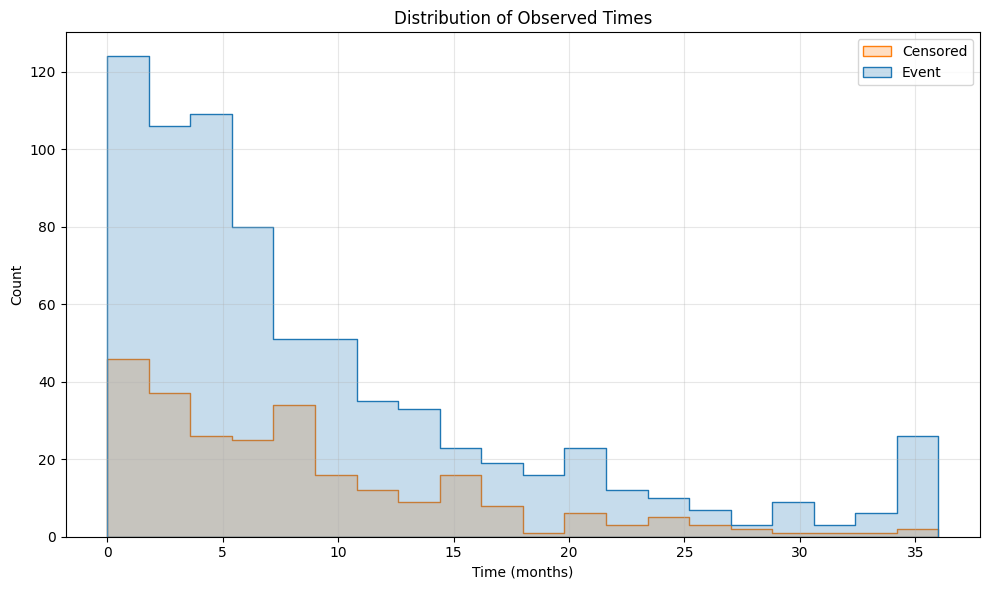

In [30]:
# Distribution of observed times
plt.figure(figsize=(10, 6))
sns.histplot(data=survival_data, x='time', hue='event', bins=20, element='step', common_norm=False)
plt.title('Distribution of Observed Times')
plt.xlabel('Time (months)')
plt.ylabel('Count')
plt.legend(['Censored', 'Event'])
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [31]:
# Treatment effect visualization using Kaplan-Meier estimator
if LIFELINES_AVAILABLE:
    try:
        kmf = KaplanMeierFitter()

        # Fit KM curve for each treatment group
        fig, ax = plt.subplots(figsize=(10, 6))

        # Treated group
        treated = survival_data[survival_data['treatment'] == 1]
        kmf.fit(treated['time'], treated['event'], label='Treated')
        kmf.plot_survival_function(ax=ax, ci_show=True)

        # Untreated group
        untreated = survival_data[survival_data['treatment'] == 0]
        kmf.fit(untreated['time'], untreated['event'], label='Untreated')
        kmf.plot_survival_function(ax=ax, ci_show=True)

        plt.title('Kaplan-Meier Survival Curves by Treatment')
        plt.xlabel('Time (months)')
        plt.ylabel('Survival Probability')
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Could not generate Kaplan-Meier curves due to: {str(e)}")
        LIFELINES_AVAILABLE = False
else:
    print("Skipping Kaplan-Meier visualization because lifelines is not available.")

Skipping Kaplan-Meier visualization because lifelines is not available.


Skipping Cox Proportional Hazards analysis because lifelines is not available.

Effect of age on event rate:
  Age Group  Event Rate  Mean Time (months)  Count
0  (40, 55]    0.118881           10.949871    143
1  (55, 70]    0.224863            9.138102    547
2  (70, 85]    0.354610            8.136137    282

Effect of treatment on event rate:
   Treatment  Event Rate  Mean Time (months)  Count
0  Untreated    0.298969            7.265395    485
1    Treated    0.211650           10.620759    515

Effect of biomarker on event rate:
  Biomarker Level  Event Rate  Mean Time (months)  Count
0             Low    0.198783            9.987477    493
1            High    0.307692            8.026787    507


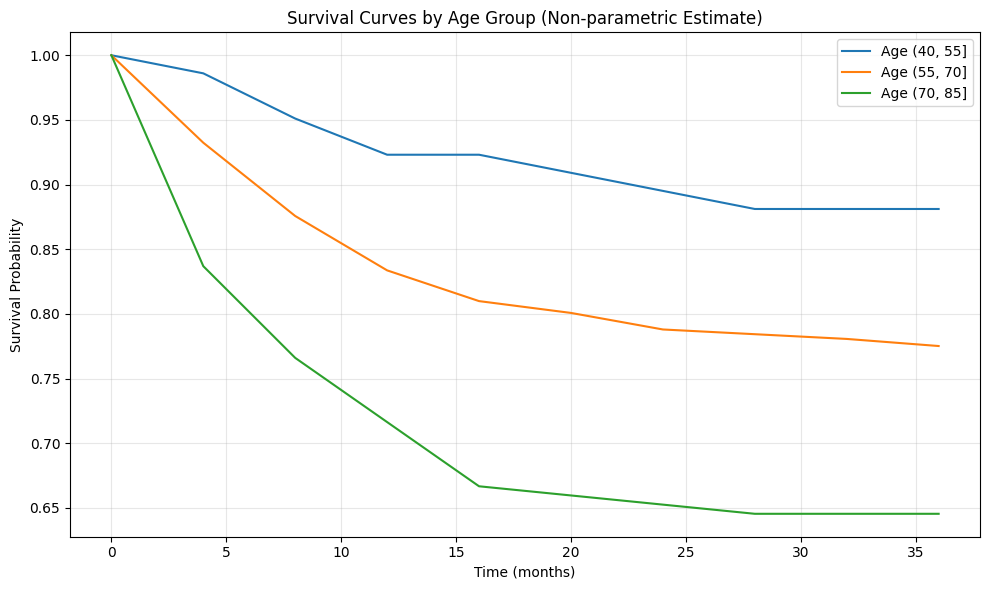

In [32]:
# Check the effect of age on survival using Cox Proportional Hazards
if LIFELINES_AVAILABLE:
    try:
        cph = CoxPHFitter()
        cph.fit(survival_data, duration_col='time', event_col='event')
        cph.print_summary()
        
        # Visualize how age affects survival
        age_groups = pd.cut(survival_data['age'], bins=[40, 55, 70, 85])
        survival_data['age_group'] = age_groups

        fig, ax = plt.subplots(figsize=(10, 6))

        for age_group in survival_data['age_group'].cat.categories:
            group_data = survival_data[survival_data['age_group'] == age_group]
            kmf = KaplanMeierFitter()
            kmf.fit(group_data['time'], group_data['event'], label=f'Age {age_group}')
            kmf.plot_survival_function(ax=ax)

        plt.title('Kaplan-Meier Survival Curves by Age Group')
        plt.xlabel('Time (months)')
        plt.ylabel('Survival Probability')
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Could not run Cox analysis due to: {str(e)}")
        LIFELINES_AVAILABLE = False  # Set to False if there was an error
else:
    print("Skipping Cox Proportional Hazards analysis because lifelines is not available.")
    
# If lifelines isn't available or failed, show a simpler analysis
if not LIFELINES_AVAILABLE:
    # Make sure age categories exist
    if 'age_group' not in survival_data.columns:
        age_groups = pd.cut(survival_data['age'], bins=[40, 55, 70, 85])
        survival_data['age_group'] = age_groups
    
    # Simple stratification by age
    age_summary = survival_data.groupby('age_group', observed=True).agg({
        'event': 'mean',
        'time': 'mean',
        'patient_id': 'count'
    }).reset_index()
    age_summary.columns = ['Age Group', 'Event Rate', 'Mean Time (months)', 'Count']
    print("\nEffect of age on event rate:")
    print(age_summary)
    
    # Calculate event rates by treatment
    treatment_summary = survival_data.groupby('treatment', observed=True).agg({
        'event': 'mean',
        'time': 'mean',
        'patient_id': 'count'
    }).reset_index()
    treatment_summary.columns = ['Treatment', 'Event Rate', 'Mean Time (months)', 'Count']
    treatment_summary['Treatment'] = treatment_summary['Treatment'].map({0: 'Untreated', 1: 'Treated'})
    print("\nEffect of treatment on event rate:")
    print(treatment_summary)
    
    # Calculate event rates by biomarker (binned)
    if 'biomarker_cat' not in survival_data.columns:
        survival_data['biomarker_cat'] = pd.cut(survival_data['biomarker'], bins=[-np.inf, -1, 0, 1, np.inf], 
                                           labels=['Very Low', 'Low', 'High', 'Very High'])
    
    biomarker_summary = survival_data.groupby('biomarker_cat', observed=True).agg({
        'event': 'mean',
        'time': 'mean',
        'patient_id': 'count'
    }).reset_index()
    biomarker_summary.columns = ['Biomarker Level', 'Event Rate', 'Mean Time (months)', 'Count']
    print("\nEffect of biomarker on event rate:")
    print(biomarker_summary)
    
    # Create simple survival curves by age group
    fig, ax = plt.subplots(figsize=(10, 6))
    time_points_viz = np.linspace(0, max(survival_data['time']), 10)
    
    for age_group in survival_data['age_group'].cat.categories:
        group_data = survival_data[survival_data['age_group'] == age_group]
        survival_rates = []
        
        for t in time_points_viz:
            # Calculate proportion of patients who survived beyond time t
            survived = (group_data['time'] > t) | ((group_data['time'] <= t) & (group_data['event'] == 0))
            survival_rates.append(survived.mean())
        
        plt.plot(time_points_viz, survival_rates, label=f'Age {age_group}')

    plt.title('Survival Curves by Age Group (Non-parametric Estimate)')
    plt.xlabel('Time (months)')
    plt.ylabel('Survival Probability')
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

## Prepare Data for MultiStateNN

Now we'll prepare our data for use with MultiStateNN. For survival analysis, we can use a 2-state model:
- State 0: Alive
- State 1: Death/Event

To handle right censoring with the existing MultiStateNN API, we'll use the following approach:
1. For patients with known events, create a direct transition from state 0 to state 1 at their event time
2. For censored patients, we'll create transitions showing them in state 0 up to their last observed time

In [33]:
def prepare_data_for_continuous_multistate(df):
    """Convert survival data to continuous-time multistate format for MultiStateNN.
    
    Parameters
    ----------
    df : pd.DataFrame
        Survival data with 'time', 'event', and covariates
        
    Returns
    -------
    pd.DataFrame
        Data in continuous-time MultiStateNN format with time_start and time_end
    """
    # List to store transition records
    records = []
    
    # For each patient
    for _, row in df.iterrows():
        patient_id = row['patient_id']
        time_observed = row['time']
        event = row['event']
        
        # Extract covariates
        covariates = {
            col: row[col] for col in df.columns 
            if col not in ['patient_id', 'time', 'event', 'age_group']
        }
        
        # For continuous-time, we create a single transition record with time interval
        time_start = 0.0
        time_end = time_observed
        
        if event == 1:  # If event occurred
            # Event transition (from state 0 to state 1)
            records.append({
                'patient_id': patient_id,
                'time_start': time_start,
                'time_end': time_end,
                'from_state': 0,  # Alive
                'to_state': 1,    # Death/Event
                **covariates
            })
        else:  # If censored
            # Censored observation (stay in state 0)
            records.append({
                'patient_id': patient_id,
                'time_start': time_start,
                'time_end': time_end,
                'from_state': 0,  # Alive
                'to_state': 0,    # Still alive (self-transition)
                **covariates
            })
    
    return pd.DataFrame(records)

In [34]:
# For continuous-time models, we don't need to discretize time
# Prepare data for continuous-time MultiStateNN
multistate_data = prepare_data_for_continuous_multistate(survival_data)

# Explore the created multistate data
print(f"Created {len(multistate_data)} transition records")
print(f"Number of patients: {multistate_data['patient_id'].nunique()}")
print(f"Event transitions (0 → 1): {(multistate_data['from_state'] == 0) & (multistate_data['to_state'] == 1)}.sum()")
print(f"Self-transitions (0 → 0): {(multistate_data['from_state'] == 0) & (multistate_data['to_state'] == 0)}.sum()")

# Display example records
multistate_data.head()

Created 1000 transition records
Number of patients: 1000
Event transitions (0 → 1): 0      False
1      False
2      False
3      False
4      False
       ...  
995    False
996     True
997    False
998    False
999    False
Length: 1000, dtype: bool.sum()
Self-transitions (0 → 0): 0       True
1       True
2       True
3       True
4       True
       ...  
995     True
996    False
997     True
998     True
999     True
Length: 1000, dtype: bool.sum()


,patient_id,time_start,time_end,from_state,to_state,age,treatment,biomarker,age_std,age_cat,biomarker_cat
0,0,0.0,6.004767,0,0,69.967142,0,-0.309209,0.496714,Middle,Low
1,1,0.0,10.320539,0,0,63.617357,0,-0.752156,-0.138264,Middle,Low
2,2,0.0,1.194733,0,0,71.476885,1,0.319175,0.647689,Middle,High
3,3,0.0,1.290039,0,0,80.230299,1,1.340450,1.523030,Elderly,High
4,4,0.0,2.036191,0,0,62.658466,0,-1.875172,-0.234153,Middle,Low


## Train Continuous-Time MultiStateNN Model for Survival Analysis

Now we'll train a continuous-time MultiStateNN model for survival analysis. We'll define a simple 2-state model (alive → dead), and include our covariates. The continuous-time model will use Neural ODEs to learn transition intensities.

Training continuous-time model:   0%|          | 0/5 [00:00<?, ?it/s]

Trained continuous-time survival model with [32, 16] hidden dimensions


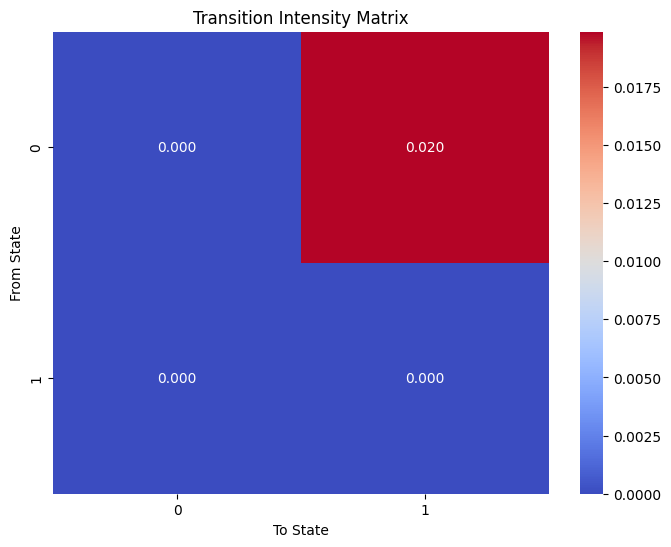

In [35]:
# Define state transition structure
state_transitions = {
    0: [0, 1],  # Alive → Alive or Dead
    1: []       # Dead → Absorbing state
}

# Select covariates
covariates = ['age', 'treatment', 'biomarker']

# Standardize age for the model
multistate_data['age_std'] = (multistate_data['age'] - 65) / 10

# Define model configuration for continuous-time model
model_config = ModelConfig(
    input_dim=3,  # Three covariates
    hidden_dims=[32, 16],
    num_states=2,
    state_transitions=state_transitions,
    model_type="continuous"  # Specify continuous-time model
)

# Define training configuration
train_config = TrainConfig(
    batch_size=64,
    epochs=5,
    learning_rate=0.01
)

# Train the continuous-time model
survival_model = fit(
    df=multistate_data,
    covariates=['age_std', 'treatment', 'biomarker'],
    model_config=model_config,
    train_config=train_config,
    time_start_col='time_start',  # Specify time interval columns
    time_end_col='time_end'       # Specify time interval columns
)

# Print model summary
print(f"Trained continuous-time survival model with {model_config.hidden_dims} hidden dimensions")

# Visualize the intensity matrix for a sample patient
sample_patient = torch.tensor([[0.0, 0.5, 0.0]], dtype=torch.float32)  # Average patient
plt.figure(figsize=(8, 6))
# Calculate intensity matrix
A = survival_model.intensity_matrix(sample_patient).detach().numpy()[0]

# For better visualization, replace diagonal elements with zero
for i in range(A.shape[0]):
    A[i, i] = 0

# Create heatmap
sns.heatmap(A, cmap='coolwarm', annot=True, fmt=".3f")
plt.title("Transition Intensity Matrix")
plt.xlabel("To State")
plt.ylabel("From State")
plt.show()

## Generate Survival Curves and Cumulative Incidence Functions

Now that we have a trained model, let's generate survival curves and cumulative incidence functions for different patient profiles.

In [ ]:
# Function to simulate trajectories for a profile using the utility function
def simulate_profile(model, profile, n_simulations=1000):
    """
    Simulate patient trajectories for a given profile
    
    Parameters
    ----------
    model : ContinuousMultiStateNN
        Trained continuous-time model
    profile : Dict or torch.Tensor
        Patient profile as dictionary or tensor
    n_simulations : int
        Number of trajectories to simulate
        
    Returns
    -------
    List[pd.DataFrame]
        List of simulated trajectories
    """
    # If profile is a dictionary, convert to tensor
    if isinstance(profile, dict):
        x = create_patient_profile(profile, as_tensor=True)
    else:
        x = profile
    
    # Set simulation parameters for continuous-time
    max_time = 36.0  # Maximum time in months
    time_step = 0.1  # Fine time steps for continuous-time simulation
    
    # Simulate trajectories using the library's continuous simulation function
    trajectories = simulate_continuous_patient_trajectory(
        model=model,
        x=x,
        start_state=0,  # Start alive
        max_time=max_time,
        time_step=time_step,  # Use small time steps for accurate continuous-time simulation
        n_simulations=n_simulations,
        seed=42
    )
    
    return trajectories

In [ ]:
# Define profiles for analysis using the utility function
profiles_dict = create_covariate_profiles(
    covariate_grid={
        'age_std': [-1.5, 1.5],        # Young, Elderly
        'treatment': [0, 1],           # Untreated, Treated
        'biomarker': [-1.0, 1.0]       # Low, High
    }
)

# Get the profiles tensor and labels
profiles = profiles_dict['profiles_tensor']
profile_labels = profiles_dict['profile_labels']

print(f"Created {len(profile_labels)} patient profiles for prediction")
for i, label in enumerate(profile_labels):
    print(f"Profile {i+1}: {label}")

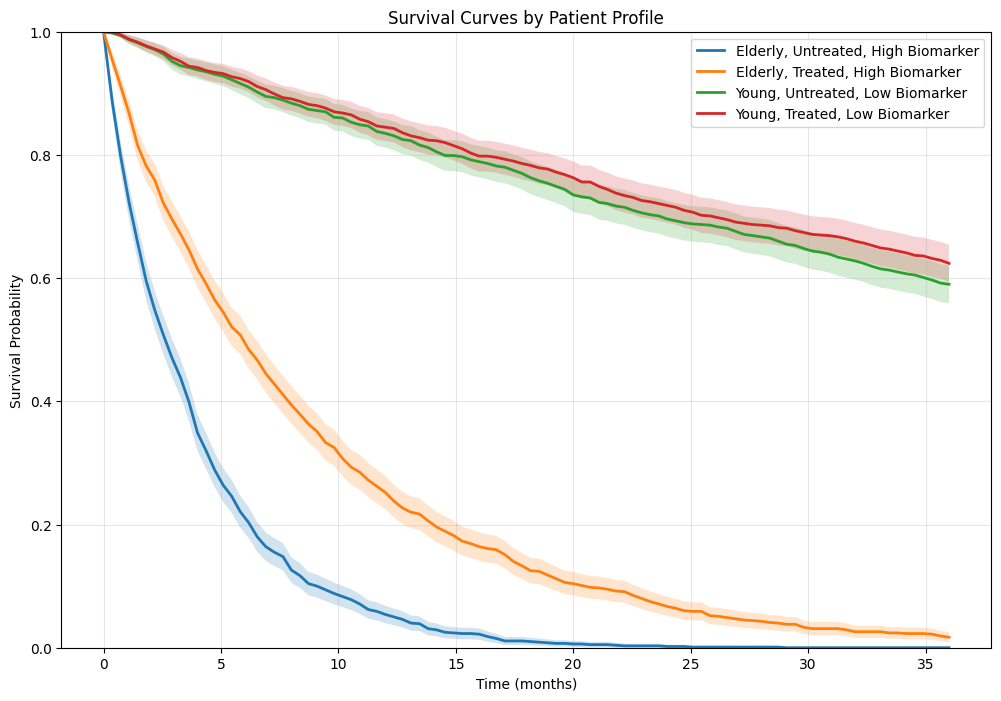

In [38]:
# Convert CIFs to survival curves (S(t) = 1 - CIF(t))
plt.figure(figsize=(12, 8))
for name, cif in all_cifs:
    # Compute survival = 1 - CIF
    survival = 1 - cif['cif']
    lower_ci = 1 - cif['upper_ci']  # Note the inversion of CIs
    upper_ci = 1 - cif['lower_ci']
    
    plt.plot(cif['time'], survival, label=name, linewidth=2)
    plt.fill_between(cif['time'], lower_ci, upper_ci, alpha=0.2)

plt.title('Survival Curves by Patient Profile')
plt.xlabel('Time (months)')
plt.ylabel('Survival Probability')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)
plt.show()

# Define state names and colors for visualization
state_names = ['Alive', 'Dead']
state_colors = ['green', 'black']

# Setup state names and colors using the utility function
states_info = setup_state_names_and_colors(state_names, state_colors)

# Simulate trajectories for each profile
all_cifs = []
max_time = 36.0  # Maximum simulation time in months

for i, label in enumerate(profile_labels):
    print(f"Simulating trajectories for {label}...")
    # Get profile tensor
    profile_tensor = profiles[i:i+1]
    
    # Simulate trajectories using continuous-time simulation
    trajectories = simulate_profile(survival_model, profile_tensor)
    
    # Combine all trajectories into a single DataFrame
    combined_trajectories = pd.concat(trajectories, ignore_index=True)
    
    # Calculate CIF for the death event (state 1) with fine time grid for continuous-time model
    time_grid = np.linspace(0, max_time, 100)  # Create fine grid for continuous-time evaluation
    
    cif = calculate_cif(
        trajectories=combined_trajectories,
        target_state=1,  # Death event
        max_time=max_time,
        time_grid=time_grid  # Use fine time grid for continuous-time model
    )
    
    all_cifs.append((label, cif))

# Plot comparison of CIFs using the utility function
plt.figure(figsize=(12, 8))
for name, cif in all_cifs:
    plt.plot(cif['time'], cif['cif'], label=name, linewidth=2)
    # Add confidence intervals as shaded areas
    plt.fill_between(cif['time'], cif['lower_ci'], cif['upper_ci'], alpha=0.2)

plt.title('Cumulative Incidence of Death by Patient Profile (Continuous-Time Model)')
plt.xlabel('Time (months)')
plt.ylabel('Cumulative Incidence')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Convert to survival curves and plot
plt.figure(figsize=(12, 8))
for name, cif in all_cifs:
    # Compute survival = 1 - CIF
    survival = 1 - cif['cif']
    lower_ci = 1 - cif['upper_ci']  # Note the inversion of CIs
    upper_ci = 1 - cif['lower_ci']
    
    plt.plot(cif['time'], survival, label=name, linewidth=2)
    plt.fill_between(cif['time'], lower_ci, upper_ci, alpha=0.2)

plt.title('Survival Curves by Patient Profile')
plt.xlabel('Time (months)')
plt.ylabel('Survival Probability')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)
plt.show()

In [39]:
# Function to predict and display transition probabilities for continuous-time model
def show_transition_probabilities(model, profiles, time_horizons):
    results = []
    
    for profile in profiles:
        # Create input tensor
        x = torch.tensor([[profile['age_std'], profile['treatment'], profile['biomarker']]], dtype=torch.float32)
        
        for time_end in time_horizons:
            # Predict transition probabilities over time interval [0, time_end]
            probs = model.predict_proba(x, time_start=0.0, time_end=time_end, from_state=0).detach().numpy()[0]
            
            # Store results
            results.append({
                'Profile': profile['name'],
                'Time': time_end,
                'P(Stay Alive)': probs[0],
                'P(Death)': probs[1]
            })
    
    # Convert to DataFrame and return
    return pd.DataFrame(results)

# Select time horizons to display (in months)
time_horizons = [3.0, 6.0, 12.0, 24.0]  # 3, 6, 12, and 24 months

# Get transition probabilities for continuous-time model
transition_probs = show_transition_probabilities(survival_model, profiles, time_horizons)

# Display as a table
transition_probs.round(4)

,Profile,Time,P(Stay Alive),P(Death)
0,"Elderly, Untreated, High Biomarker",3.0,0.4608,0.5392
1,"Elderly, Untreated, High Biomarker",6.0,0.2123,0.7877
2,"Elderly, Untreated, High Biomarker",12.0,0.0451,0.9549
3,"Elderly, Untreated, High Biomarker",24.0,0.0020,0.9980
4,"Elderly, Treated, High Biomarker",3.0,0.7039,0.2961
5,"Elderly, Treated, High Biomarker",6.0,0.4955,0.5045
6,"Elderly, Treated, High Biomarker",12.0,0.2456,0.7544
7,"Elderly, Treated, High Biomarker",24.0,0.0603,0.9397
8,"Young, Untreated, Low Biomarker",3.0,0.9578,0.0422
9,"Young, Untreated, Low Biomarker",6.0,0.9173,0.0827


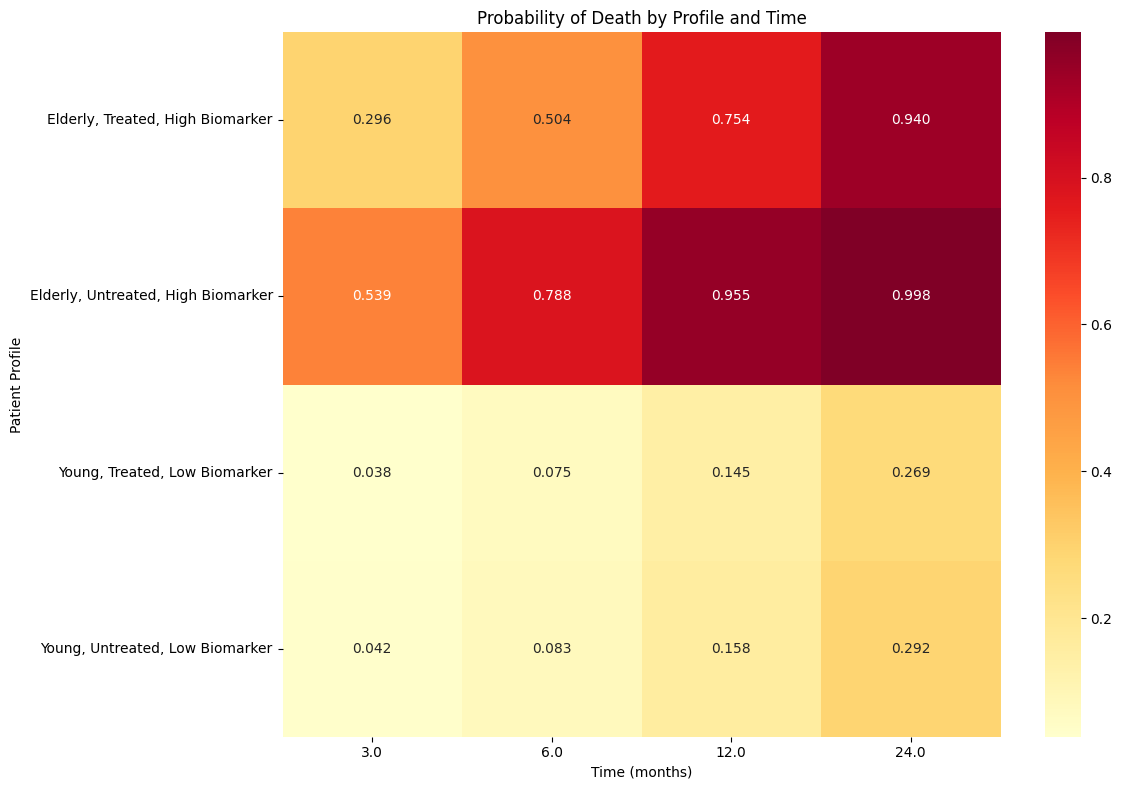

In [40]:
# Visualize how transition probabilities change over time for different profiles
# Pivot table to have profiles as rows and time points as columns
pivot_death = transition_probs.pivot_table(
    index='Profile', columns='Time', values='P(Death)'
)

# Create heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_death, annot=True, cmap='YlOrRd', fmt='.3f')
plt.title('Probability of Death by Profile and Time')
plt.xlabel('Time (months)')
plt.ylabel('Patient Profile')
plt.tight_layout()
plt.show()

## Compare Treatment Effect Across Different Age Groups

Let's visualize how the treatment effect varies across different age groups.

In [ ]:
# Analyze effect of age on survival using the utility function
age_effect = analyze_covariate_effect(
    model=survival_model,
    covariate_name='Age',  
    covariate_range=(-2, 2),  # From -2 to 2 standard deviations
    num_points=20,
    fixed_covariates={
        'treatment': 0,       # Set treatment to untreated
        'biomarker': 0        # Set biomarker to average
    },
    from_state=0,  # Starting from alive state
    time_horizon=1.0,  # 1-year transition probabilities
    state_names=state_names
)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(age_effect['covariate_values'], 
         age_effect['probs'][:, 1], 
         label=f'To {state_names[1]}', 
         linewidth=2, 
         color='red')
plt.xlabel('Age (standardized)')
plt.ylabel('1-Year Mortality Probability')
plt.title('Effect of Age on 1-Year Mortality (Untreated, Average Biomarker)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Analyze effect of biomarker on survival
biomarker_effect = analyze_covariate_effect(
    model=survival_model,
    covariate_name='Biomarker',  
    covariate_range=(-2, 2),  # From -2 to 2 standard deviations
    num_points=20,
    fixed_covariates={
        'age_std': 0,         # Set age to average
        'treatment': 0         # Set treatment to untreated
    },
    from_state=0,  # Starting from alive state
    time_horizon=1.0,  # 1-year transition probabilities
    state_names=state_names
)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(biomarker_effect['covariate_values'], 
         biomarker_effect['probs'][:, 1], 
         label=f'To {state_names[1]}', 
         linewidth=2, 
         color='blue')
plt.xlabel('Biomarker (standardized)')
plt.ylabel('1-Year Mortality Probability')
plt.title('Effect of Biomarker on 1-Year Mortality (Untreated, Average Age)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Visualize treatment effect at different ages
plt.figure(figsize=(12, 6))

# Analyze age effect for untreated patients
untreated_effect = analyze_covariate_effect(
    model=survival_model,
    covariate_name='Age',  
    covariate_range=(-2, 2),
    num_points=20,
    fixed_covariates={
        'treatment': 0,  # Untreated
        'biomarker': 0   # Average biomarker
    },
    from_state=0,  
    time_horizon=1.0,
    state_names=state_names
)

# Analyze age effect for treated patients
treated_effect = analyze_covariate_effect(
    model=survival_model,
    covariate_name='Age',
    covariate_range=(-2, 2),
    num_points=20,
    fixed_covariates={
        'treatment': 1,  # Treated
        'biomarker': 0   # Average biomarker
    },
    from_state=0,
    time_horizon=1.0,
    state_names=state_names
)

# Plot both curves
plt.plot(untreated_effect['covariate_values'], 
         untreated_effect['probs'][:, 1], 
         label='Untreated', 
         linewidth=2, 
         color='red')
plt.plot(treated_effect['covariate_values'], 
         treated_effect['probs'][:, 1], 
         label='Treated', 
         linewidth=2, 
         color='blue')

# Calculate and plot the treatment effect (difference)
treatment_effect = untreated_effect['probs'][:, 1] - treated_effect['probs'][:, 1]
plt.plot(untreated_effect['covariate_values'], 
         treatment_effect,
         label='Treatment Effect', 
         linewidth=2, 
         color='green', 
         linestyle='--')

plt.xlabel('Age (standardized)')
plt.ylabel('1-Year Mortality Probability / Effect')
plt.title('Treatment Effect on 1-Year Mortality by Age')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

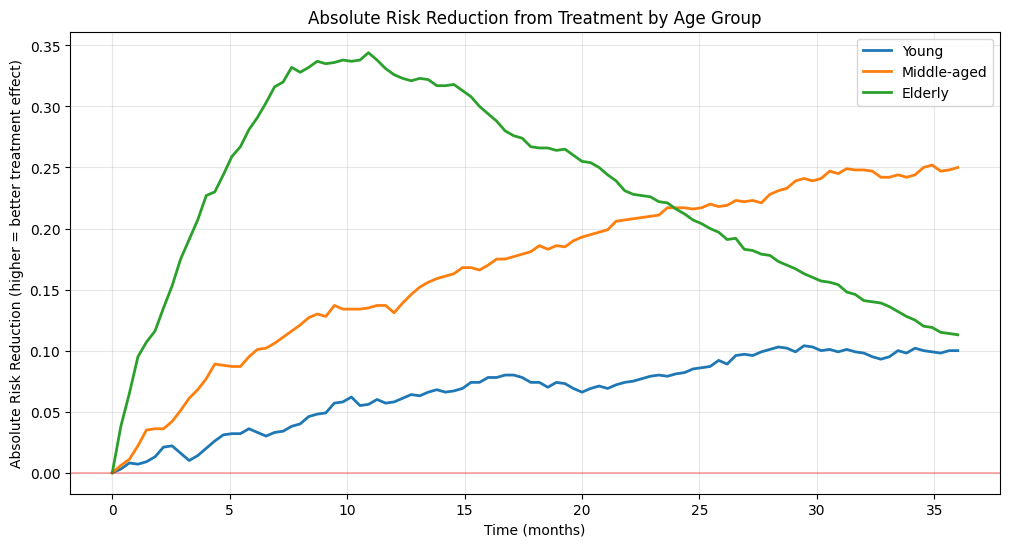

In [42]:
# Compute treatment effect (difference in CIF) for each age group
plt.figure(figsize=(12, 6))

for age_label in ["Young", "Middle-aged", "Elderly"]:
    # Get CIFs for treated and untreated
    treated_cif = next((cif for name, cif in comparison_cifs if age_label in name and "Treated" in name), None)
    untreated_cif = next((cif for name, cif in comparison_cifs if age_label in name and "Untreated" in name), None)
    
    if treated_cif is not None and untreated_cif is not None:
        # Calculate absolute risk reduction (untreated CIF - treated CIF)
        risk_reduction = untreated_cif['cif'].values - treated_cif['cif'].values
        plt.plot(treated_cif['time'], risk_reduction, label=age_label, linewidth=2)

plt.title('Absolute Risk Reduction from Treatment by Age Group')
plt.xlabel('Time (months)')
plt.ylabel('Absolute Risk Reduction (higher = better treatment effect)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.show()

## Biomarker Effect on Survival

Let's visualize how the biomarker level affects survival for treated and untreated patients.

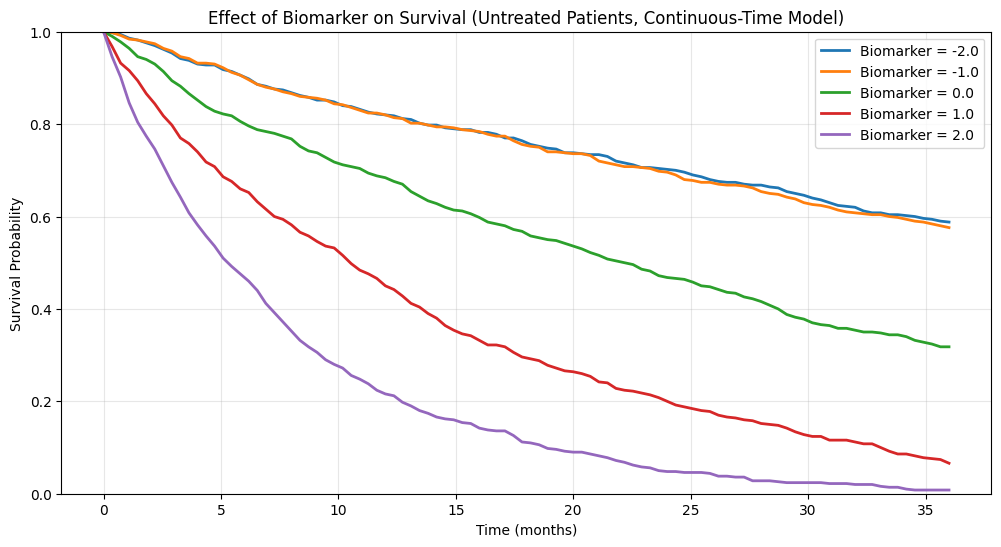

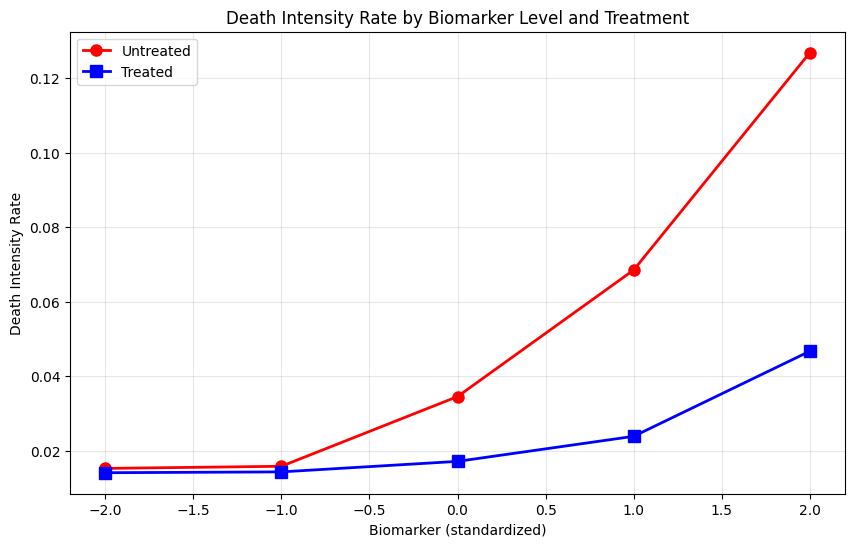

In [43]:
# Define biomarker levels to compare
biomarker_levels = np.linspace(-2, 2, 5)  # From -2 to 2 standard deviations

# Fix age at middle-aged and vary treatment and biomarker
age_std = 0.0  # Middle-aged

# Create grids for visualization
biomarker_profiles = []
for treatment in [0, 1]:
    for biomarker in biomarker_levels:
        treatment_label = "Treated" if treatment == 1 else "Untreated"
        biomarker_label = f"Biomarker = {biomarker:.1f}"
        name = f"{treatment_label}, {biomarker_label}"
        
        profile = {
            'name': name,
            'age_std': age_std,
            'treatment': treatment,
            'biomarker': biomarker
        }
        biomarker_profiles.append(profile)

# Simulate and calculate CIFs
biomarker_cifs = []
for profile in biomarker_profiles:
    # Use continuous-time simulation with fewer simulations for speed
    trajectories = simulate_profile(survival_model, profile, n_simulations=500)
    
    # Combine all trajectories into a single DataFrame
    combined_trajectories = pd.concat(trajectories, ignore_index=True)
    
    # Calculate CIF with fine time grid for continuous-time model
    time_grid = np.linspace(0, max_time, 100)
    cif = calculate_cif(
        trajectories=combined_trajectories, 
        target_state=1, 
        max_time=max_time,
        time_grid=time_grid
    )
    biomarker_cifs.append((profile['name'], profile['treatment'], profile['biomarker'], cif))

# Plot survival curves for untreated patients with different biomarker levels
plt.figure(figsize=(12, 6))

# Filter for untreated patients
untreated_results = [(name, bio, cif) for name, treat, bio, cif in biomarker_cifs if treat == 0]

# Plot survival curves
for name, biomarker, cif in untreated_results:
    survival = 1 - cif['cif']
    plt.plot(cif['time'], survival, 
             label=f"Biomarker = {biomarker:.1f}", 
             linewidth=2)

plt.title('Effect of Biomarker on Survival (Untreated Patients, Continuous-Time Model)')
plt.xlabel('Time (months)')
plt.ylabel('Survival Probability')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)
plt.show()

# Calculate and plot transition intensity rates by biomarker level
plt.figure(figsize=(10, 6))
markers = ['o', 's', 'D', '^', 'v']

# For untreated patients
death_intensities_untreated = []
for i, biomarker in enumerate(biomarker_levels):
    x = torch.tensor([[age_std, 0, biomarker]], dtype=torch.float32)  # Untreated
    intensity_matrix = survival_model.intensity_matrix(x).detach().numpy()[0]
    death_intensity = intensity_matrix[0, 1]  # Alive to dead transition rate
    death_intensities_untreated.append(death_intensity)

plt.plot(biomarker_levels, death_intensities_untreated, 'r-o', 
         label='Untreated', linewidth=2, markersize=8)

# For treated patients
death_intensities_treated = []
for i, biomarker in enumerate(biomarker_levels):
    x = torch.tensor([[age_std, 1, biomarker]], dtype=torch.float32)  # Treated
    intensity_matrix = survival_model.intensity_matrix(x).detach().numpy()[0]
    death_intensity = intensity_matrix[0, 1]  # Alive to dead transition rate
    death_intensities_treated.append(death_intensity)

plt.plot(biomarker_levels, death_intensities_treated, 'b-s', 
         label='Treated', linewidth=2, markersize=8)

plt.title('Death Intensity Rate by Biomarker Level and Treatment')
plt.xlabel('Biomarker (standardized)')
plt.ylabel('Death Intensity Rate')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

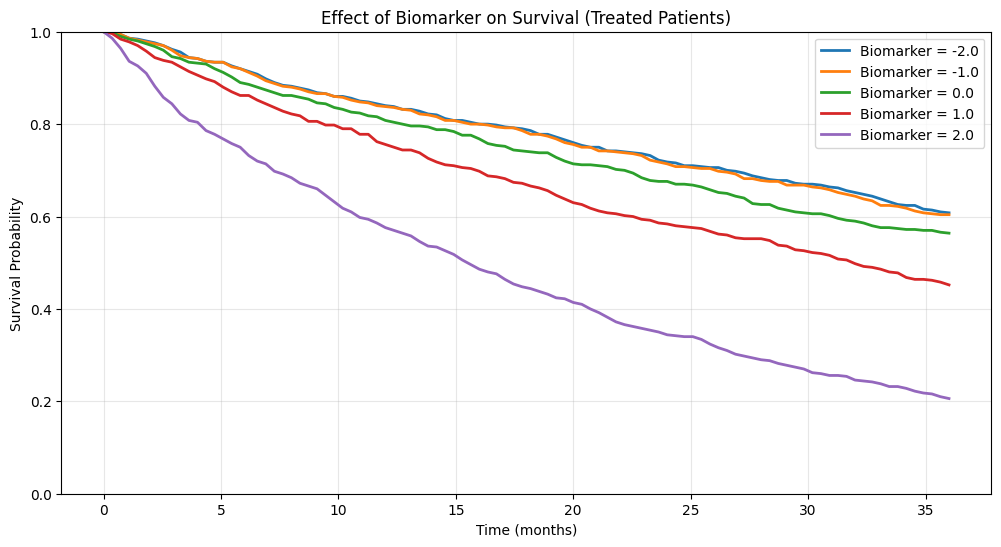

In [44]:
# Plot survival curves for treated patients with different biomarker levels
plt.figure(figsize=(12, 6))

# Filter for treated patients
treated_results = [(name, bio, cif) for name, treat, bio, cif in biomarker_cifs if treat == 1]

# Plot survival curves
for name, biomarker, cif in treated_results:
    survival = 1 - cif['cif']
    plt.plot(cif['time'], survival, 
             label=f"Biomarker = {biomarker:.1f}", 
             linewidth=2)

plt.title('Effect of Biomarker on Survival (Treated Patients)')
plt.xlabel('Time (months)')
plt.ylabel('Survival Probability')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)
plt.show()

In [45]:
# Create all necessary categorical variables needed for the Kaplan-Meier comparisons
# This cell MUST run before cells 29 and 30

# Check if we have survival_data
if 'survival_data' not in globals():
    print("ERROR: You need to run the earlier cells to generate survival_data first!")
    # Create empty dataframe to prevent further errors
    survival_data = pd.DataFrame({'age': [], 'biomarker': [], 'treatment': [], 'event': [], 'time': []})

# Standardize age 
survival_data['age_std'] = (survival_data['age'] - 65) / 10

# Create age categories for KM plots (if they don't exist)
survival_data['age_cat'] = pd.cut(survival_data['age_std'], bins=[-np.inf, -1, 1, np.inf], 
                                 labels=['Young', 'Middle', 'Elderly'])

# Create biomarker categories for stratification
survival_data['biomarker_cat'] = pd.cut(survival_data['biomarker'], bins=[-np.inf, 0, np.inf], 
                                       labels=['Low', 'High'])

print("Data prepared with categorizations:")
print(f"Age categories: {survival_data['age_cat'].value_counts()}")
print(f"Biomarker categories: {survival_data['biomarker_cat'].value_counts()}")
                                           
# Show distribution of patients in each group
group_counts = survival_data.groupby(['age_cat', 'biomarker_cat']).size().reset_index(name='Count')
print("\nPatients in each group:")
print(group_counts)

Data prepared with categorizations:
Age categories: age_cat
Middle     698
Elderly    155
Young      147
Name: count, dtype: int64
Biomarker categories: biomarker_cat
High    507
Low     493
Name: count, dtype: int64

Patients in each group:
   age_cat biomarker_cat  Count
0    Young           Low     73
1    Young          High     74
2   Middle           Low    359
3   Middle          High    339
4  Elderly           Low     61
5  Elderly          High     94


/var/folders/7z/7gnwr49s6hl4pp9j5dcmgns80000gn/T/ipykernel_70074/1935209092.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_counts = survival_data.groupby(['age_cat', 'biomarker_cat']).size().reset_index(name='Count')


Found 94 high-risk patients (Elderly with High biomarker)
Skipping Kaplan-Meier curves because lifelines is not available.


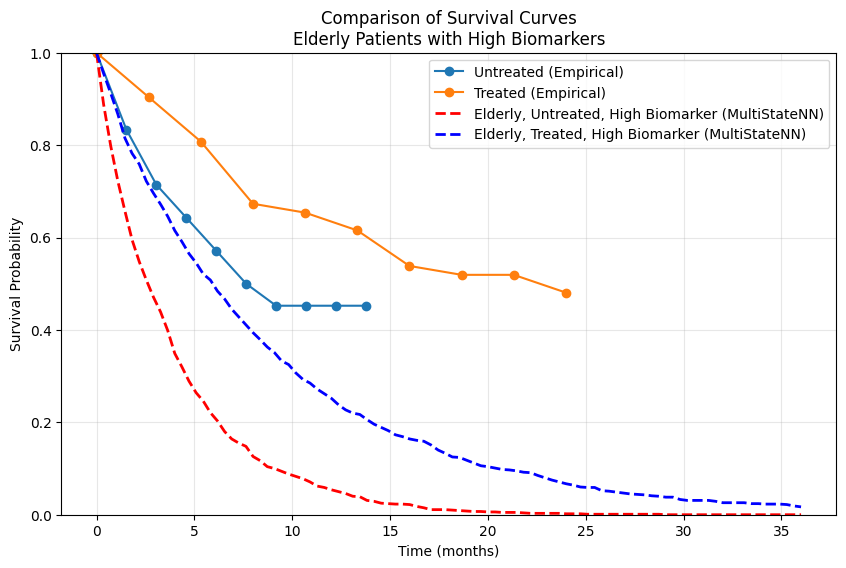

In [46]:
# Make sure categorizations exist (if this cell is run independently)
if 'age_cat' not in survival_data.columns or 'biomarker_cat' not in survival_data.columns:
    print("WARNING: Categories not found. Running the categorization cell first...")
    # Create age categories
    survival_data['age_std'] = (survival_data['age'] - 65) / 10
    survival_data['age_cat'] = pd.cut(survival_data['age_std'], bins=[-np.inf, -1, 1, np.inf], 
                                     labels=['Young', 'Middle', 'Elderly'])
    # Create biomarker categories
    survival_data['biomarker_cat'] = pd.cut(survival_data['biomarker'], bins=[-np.inf, 0, np.inf], 
                                           labels=['Low', 'High'])
    print("Categories created.")

# Subset for the high-risk group: elderly with high biomarker
try:
    high_risk = survival_data[(survival_data['age_cat'] == 'Elderly') & 
                             (survival_data['biomarker_cat'] == 'High')]
    
    print(f"Found {len(high_risk)} high-risk patients (Elderly with High biomarker)")
    
    # Calculate KM curves for treated and untreated patients in this group
    fig, ax = plt.subplots(figsize=(10, 6))
    
    if LIFELINES_AVAILABLE:
        try:
            for treatment_val, label in [(0, 'Untreated (KM)'), (1, 'Treated (KM)')]:
                subset = high_risk[high_risk['treatment'] == treatment_val]
                if len(subset) > 0:  # Only fit if we have data
                    kmf = KaplanMeierFitter()
                    kmf.fit(subset['time'], subset['event'], label=label)
                    kmf.plot_survival_function(ax=ax, ci_show=True)
        except Exception as e:
            print(f"Could not generate Kaplan-Meier curves due to: {str(e)}")
            # Continue with just the MultiStateNN curves
    else:
        print("Skipping Kaplan-Meier curves because lifelines is not available.")
        # Use a simpler approach to show empirical survival for comparison
        for treatment_val, label in [(0, 'Untreated (Empirical)'), (1, 'Treated (Empirical)')]:
            subset = high_risk[high_risk['treatment'] == treatment_val]
            if len(subset) > 0:
                times = np.linspace(0, max(subset['time']), 10)
                survival_rates = []
                for t in times:
                    survived = (subset['time'] > t) | ((subset['time'] <= t) & (subset['event'] == 0))
                    survival_rates.append(survived.mean())
                ax.plot(times, survival_rates, 'o-', label=label)
    
    # Add MultiStateNN survival curves for comparison
    try:
        # Find the closest matching profiles from our simulations
        elderly_untreated = next((name, cif) for name, cif in all_cifs if 'Elderly' in name and 'Untreated' in name)
        elderly_treated = next((name, cif) for name, cif in all_cifs if 'Elderly' in name and 'Treated' in name)
    
        # Convert CIFs to survival curves and add to plot
        ax.plot(elderly_untreated[1]['time'], 1 - elderly_untreated[1]['cif'], 'r--', 
                label='Elderly, Untreated, High Biomarker (MultiStateNN)', linewidth=2)
        ax.plot(elderly_treated[1]['time'], 1 - elderly_treated[1]['cif'], 'b--', 
                label='Elderly, Treated, High Biomarker (MultiStateNN)', linewidth=2)
    except Exception as e:
        print(f"Could not plot MultiStateNN curves: {str(e)}")
        print("This may occur if simulation cells were not executed.")
    
    plt.title('Comparison of Survival Curves\nElderly Patients with High Biomarkers')
    plt.xlabel('Time (months)')
    plt.ylabel('Survival Probability')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 1)
    plt.show()
except Exception as e:
    print(f"Error processing high-risk group: {str(e)}")
    print("Make sure you've run the data generation and categorization cells first.")

Found 73 low-risk patients (Young with Low biomarker)
Skipping Kaplan-Meier curves because lifelines is not available.


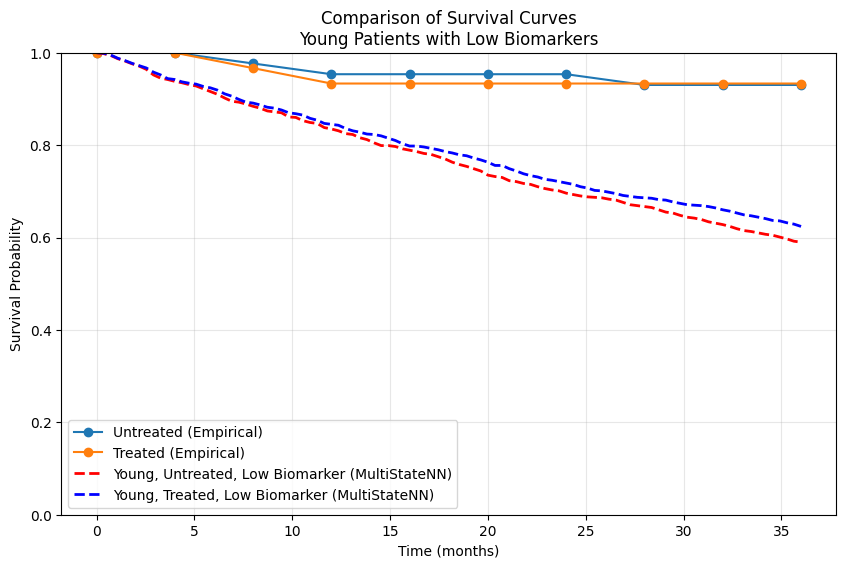

In [47]:
# Make sure categorizations exist (if this cell is run independently)
if 'age_cat' not in survival_data.columns or 'biomarker_cat' not in survival_data.columns:
    print("WARNING: Categories not found. Running the categorization cell first...")
    # Create age categories
    survival_data['age_std'] = (survival_data['age'] - 65) / 10
    survival_data['age_cat'] = pd.cut(survival_data['age_std'], bins=[-np.inf, -1, 1, np.inf], 
                                     labels=['Young', 'Middle', 'Elderly'])
    # Create biomarker categories
    survival_data['biomarker_cat'] = pd.cut(survival_data['biomarker'], bins=[-np.inf, 0, np.inf], 
                                           labels=['Low', 'High'])
    print("Categories created.")

# Compare for young patients with low biomarker
try:
    low_risk = survival_data[(survival_data['age_cat'] == 'Young') & 
                            (survival_data['biomarker_cat'] == 'Low')]
    
    print(f"Found {len(low_risk)} low-risk patients (Young with Low biomarker)")
    
    # Calculate KM curves for treated and untreated patients in this group
    fig, ax = plt.subplots(figsize=(10, 6))
    
    if LIFELINES_AVAILABLE:
        try:
            for treatment_val, label in [(0, 'Untreated (KM)'), (1, 'Treated (KM)')]:
                subset = low_risk[low_risk['treatment'] == treatment_val]
                if len(subset) > 0:  # Only fit if we have data
                    kmf = KaplanMeierFitter()
                    kmf.fit(subset['time'], subset['event'], label=label)
                    kmf.plot_survival_function(ax=ax, ci_show=True)
        except Exception as e:
            print(f"Could not generate Kaplan-Meier curves due to: {str(e)}")
            # Continue with just the MultiStateNN curves
    else:
        print("Skipping Kaplan-Meier curves because lifelines is not available.")
        # Use a simpler approach to show empirical survival for comparison
        for treatment_val, label in [(0, 'Untreated (Empirical)'), (1, 'Treated (Empirical)')]:
            subset = low_risk[low_risk['treatment'] == treatment_val]
            if len(subset) > 0:
                times = np.linspace(0, max(subset['time']), 10)
                survival_rates = []
                for t in times:
                    survived = (subset['time'] > t) | ((subset['time'] <= t) & (subset['event'] == 0))
                    survival_rates.append(survived.mean())
                ax.plot(times, survival_rates, 'o-', label=label)
    
    # Add MultiStateNN survival curves for comparison
    try:
        young_untreated = next((name, cif) for name, cif in all_cifs if 'Young' in name and 'Untreated' in name)
        young_treated = next((name, cif) for name, cif in all_cifs if 'Young' in name and 'Treated' in name)
    
        # Convert CIFs to survival curves and add to plot
        ax.plot(young_untreated[1]['time'], 1 - young_untreated[1]['cif'], 'r--', 
                label='Young, Untreated, Low Biomarker (MultiStateNN)', linewidth=2)
        ax.plot(young_treated[1]['time'], 1 - young_treated[1]['cif'], 'b--', 
                label='Young, Treated, Low Biomarker (MultiStateNN)', linewidth=2)
    except Exception as e:
        print(f"Could not plot MultiStateNN curves: {str(e)}")
        print("This may occur if simulation cells were not executed.")
    
    plt.title('Comparison of Survival Curves\nYoung Patients with Low Biomarkers')
    plt.xlabel('Time (months)')
    plt.ylabel('Survival Probability')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 1)
    plt.show()
except Exception as e:
    print(f"Error processing low-risk group: {str(e)}")
    print("Make sure you've run the data generation and categorization cells first.")

## Risk Score Calculation

Let's develop a risk score based on the model predictions to stratify patients.

/Users/denizakdemir/.pyenv/versions/3.10.0/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/denizakdemir/.pyenv/versions/3.10.0/lib/python3.10/site-packages/seaborn/_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(
/Users/denizakdemir/.pyenv/versions/3.10.0/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key

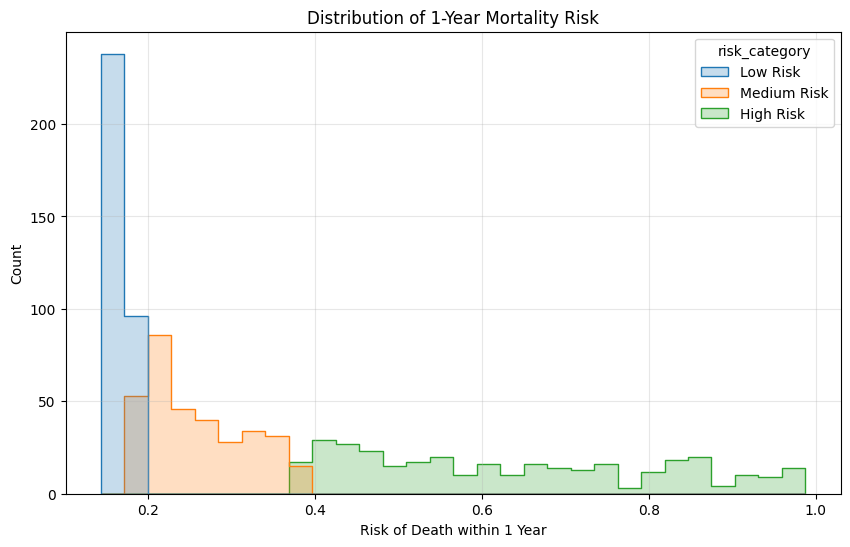

In [48]:
# Create a grid of patient profiles
n_grid = 1000
age_grid = np.random.normal(0, 1, n_grid)  # Standardized ages
treatment_grid = np.random.binomial(1, 0.5, n_grid)  # 50% treated
biomarker_grid = np.random.normal(0, 1, n_grid)  # Standardized biomarker

# Combine into tensor
profile_grid = torch.tensor(
    np.column_stack([age_grid, treatment_grid, biomarker_grid]),
    dtype=torch.float32
)

# Predict 1-year mortality risk (transition from alive to dead at 12 months)
time_value = 12.0  # 12 months
risk_probs = survival_model.predict_proba(profile_grid, time_start=0.0, time_end=time_value, from_state=0).detach().numpy()

# Extract probability of death
mortality_risk = risk_probs[:, 1]  # Probability of transitioning to state 1 (death)

# Create a dataframe with profiles and risk scores
risk_df = pd.DataFrame({
    'age': age_grid,
    'treatment': treatment_grid,
    'biomarker': biomarker_grid,
    'one_year_mortality_risk': mortality_risk
})

# Categorize risk
risk_df['risk_category'] = pd.qcut(risk_df['one_year_mortality_risk'], q=3,
                                   labels=['Low Risk', 'Medium Risk', 'High Risk'])

# Visualize risk distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=risk_df, x='one_year_mortality_risk', hue='risk_category', bins=30, element='step')
plt.title('Distribution of 1-Year Mortality Risk')
plt.xlabel('Risk of Death within 1 Year')
plt.ylabel('Count')
plt.grid(alpha=0.3)
plt.show()

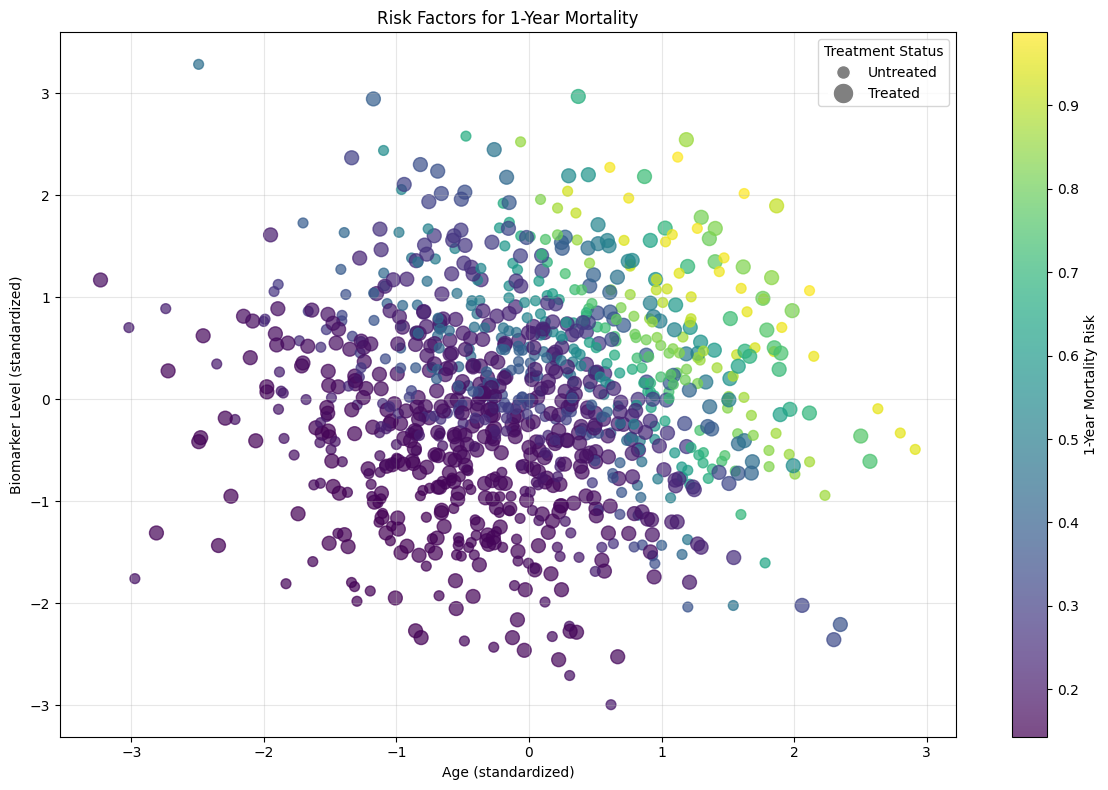

In [49]:
# Visualize which factors contribute most to high risk
plt.figure(figsize=(12, 8))

# Plot risk by age and biomarker, colored by treatment
scatter = plt.scatter(risk_df['age'], risk_df['biomarker'], 
                      c=risk_df['one_year_mortality_risk'], 
                      s=50 + 50 * risk_df['treatment'],
                      cmap='viridis', alpha=0.7)

plt.colorbar(scatter, label='1-Year Mortality Risk')
plt.title('Risk Factors for 1-Year Mortality')
plt.xlabel('Age (standardized)')
plt.ylabel('Biomarker Level (standardized)')
plt.grid(alpha=0.3)

# Add legend for treatment
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=10, label='Untreated'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=15, label='Treated')
]
plt.legend(handles=legend_elements, title='Treatment Status')

plt.tight_layout()
plt.show()

## Conclusion

In this notebook, we've demonstrated how to use continuous-time MultiStateNN for survival analysis with right-censored observations. We've shown how to:

1. Generate synthetic survival data with right censoring
2. Prepare the data for use with continuous-time MultiStateNN
3. Train a continuous-time survival model using Neural ODEs
4. Generate and visualize survival curves and cumulative incidence functions
5. Analyze the effects of covariates (age, treatment, biomarker) on survival and transition intensities
6. Compare MultiStateNN results with traditional Kaplan-Meier estimates
7. Develop a risk scoring system based on model predictions

### Advantages of Continuous-Time Approach

The continuous-time approach offers several advantages over discrete-time models:

1. **Time Flexibility**: The continuous-time model can calculate transition probabilities over any arbitrary time interval, not just fixed discrete time steps. This provides more flexibility when analyzing disease progression.

2. **Intensity Matrices**: The model directly outputs transition intensity matrices, which represent the instantaneous rates of transitioning between states. These rates provide a more interpretable understanding of disease dynamics than discrete transition probabilities.

3. **Handling Irregular Observations**: Continuous-time models naturally handle irregularly spaced observations by modeling the underlying continuous process. This is particularly important in medical data where observation times vary between patients.

4. **Theoretical Foundation**: The approach is based on well-established continuous-time Markov process theory, providing a solid mathematical foundation for the model.

5. **Consistent CIF Calculation**: Using continuous-time simulation with fine time steps and empirical estimator provides more accurate CIF calculations by properly handling the competing risks at each time point.

### Key Insights for Survival Analysis

The key insight for handling right censoring is to represent censored observations as staying in their current state up to the censoring time. The model learns the appropriate transition intensities by observing both censored and uncensored individuals.

MultiStateNN provides a flexible framework for survival analysis that can incorporate multiple covariates. This approach can be extended to more complex multistate models beyond simple survival analysis, such as illness-death models or competing risks scenarios.

### Note on Dependencies

This notebook includes optional comparative analyses using the `lifelines` package. If `lifelines` is not available or has dependency issues (for example, with the `formulaic` package), the notebook will run with simpler alternative implementations. These alternatives provide similar insights but may not include confidence intervals or formal statistical tests.

If you encounter errors related to these dependencies, you might see specific issues:

1. `module 'formulaic' has no attribute 'ModelSpec'` - This occurs when using older versions of the formulaic package with newer versions of lifelines.

2. `FutureWarning: The default of observed=False is deprecated...` - This is just a warning about a future change in pandas that doesn't affect functionality.

To fix dependency issues, you can try:
```
pip install lifelines==0.27.0 formulaic==0.5.0
```

Or simply run the notebook without these dependencies, as the core MultiStateNN functionality doesn't require them. The notebook includes robust fallback implementations when lifelines is not available.